In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
# import statsmodels.api as sm
import os
import seaborn as sns
sns.set()
from joblib import dump
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D

## BUILDING THE DATASET

In [2]:
#create dataset
data = pd.DataFrame(columns=['RSSI', 'distance'])

# Reading gathered data files
files_list = sorted(list(filter(lambda x: ("detectedDevs" in x), os.listdir("."))))

#concatenate file's data to build the dataset
for file in files_list:
    filename_split = file.split('_')
    distance = float(filename_split[2]) / 100
    df = pd.read_json('./'+file)

    df.drop(['devname', 'launchpadId'], axis=1, inplace=True)
    df.insert(loc=1, column='distance', value=np.repeat(distance, df.shape[0]))

    data = data.append(df)

data.reset_index(drop=True, inplace=True)

#create the column "dist_<_1m" to allow performing classification
data.insert(2, 'dist_<_1m', data['distance'].apply(lambda dist: 1 if dist < 1.0 else 0))
data

,RSSI,distance,dist_<_1m
0,-25,0.0,1
1,-25,0.0,1
2,-25,0.0,1
3,-25,0.0,1
4,-25,0.0,1
...,...,...,...
12109,-55,0.8,1
12110,-48,0.8,1
12111,-48,0.8,1
12112,-46,0.8,1


## PREPROCESSING

In [3]:
#imbalanced dataset. down-sample majority class
data_maj = data[data['dist_<_1m'] == 1]
data_min = data[data['dist_<_1m'] == 0]

data_maj_downsampled = resample(data_maj, replace=False, n_samples=data_min.shape[0], random_state=176341)

data = pd.concat([data_maj_downsampled, data_min])
print(data)
print(data['dist_<_1m'].value_counts())

      RSSI  distance  dist_<_1m
3643   -48       0.8          1
4164   -26       0.0          1
3585   -46       0.8          1
8342   -27       0.0          1
7163   -43       0.6          1
...    ...       ...        ...
10594  -63       3.0          0
10595  -63       3.0          0
10596  -64       3.0          0
10597  -61       3.0          0
10598  -61       3.0          0

[9082 rows x 3 columns]
1    4541
0    4541
Name: dist_<_1m, dtype: int64


Text(0.5, 1.0, 'Mixed data')

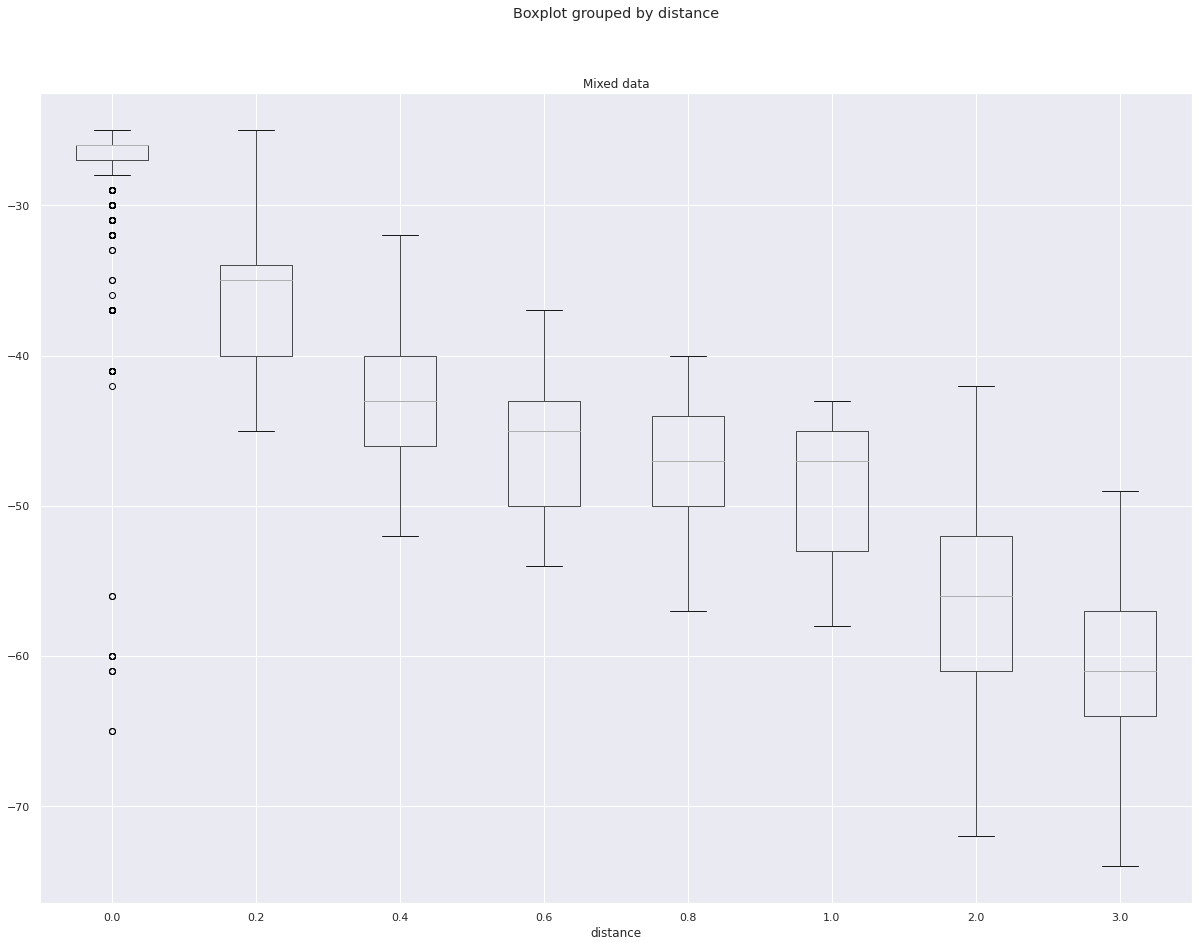

In [4]:
#Mixing data from all anchors
fig, ax = plt.subplots(figsize=(20,15))

data.boxplot(column='RSSI', by='distance', ax=ax)
ax.set_title("Mixed data")

In [5]:
#Remove distance=0 outliers  
indexnames = data[(data.distance == 0) & (data.RSSI < -35)].index
data.drop(indexnames, inplace=True, axis=0)

## USING GAUSSIAN NAIVE BAYES MODEL

### BUILDING TRAIN & TEST SETS

In [6]:
#split in train and test data
X_train, X_test, y_train, y_test = train_test_split(np.array(data['RSSI']).reshape(-1,1), np.array(data['dist_<_1m']).reshape(-1,1), test_size=data.shape[0]//3)

### APPLY GAUSSIAN NAIVE-BAYES

In [7]:
#apply a gaussian naive-bayes
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

#using cross validation
NB_model_cv = GaussianNB()
scores = cross_val_score(NB_model_cv, X_train, y_train, cv=10, scoring='f1_macro')

print(f'cross validation accuracy f1_macro score:\n mean={scores.mean()}\n std={scores.std()}\n')

cross validation accuracy f1_macro score:
 mean=0.8147292563562443
 std=0.009306037793008879



## USING SVC

### BUILDING TRAIN & TEST SETS

In [8]:
#split in train and test data
X_train, X_test, y_train, y_test = train_test_split(np.array(data['RSSI']).reshape(-1,1), np.array(data['dist_<_1m']).reshape(-1,1), test_size=data.shape[0]//3)

### SCALE TRAIN & TEST SETS SEPARATELY

In [18]:
#NO HACE FALTA ESCALAR PORQUE SOLO HAY UNA FEATURE
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

### INITIALIZING LISTS OF HYPERPARAMETERS FOR GRIDSEARCH

In [9]:
kernels = ['linear', 'rbf', 'sigmoid']
Cs = [0.001, 0.1, 1, 10, 100, 1000]
gammas = [0.1, 0.5, 1]

### APPLY SVC

In [10]:
svc = SVC(class_weight='balanced')

trc = GridSearchCV(estimator=svc,
                   param_grid={
                       'C': Cs,
                       'kernel': kernels,
                       'gamma': gammas
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=10,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

svc_model_10CV = trc.fit(X_train, y_train)

print(svc_model_10CV.best_score_)
print(svc_model_10CV.best_params_)

0.8374688923478356
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [11]:
pd.DataFrame(svc_model_10CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_C',
    'param_kernel',
    'param_gamma',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

,mean_fit_time,std_fit_time,param_C,param_kernel,param_gamma,mean_test_accuracy,std_test_accuracy,mean_test_recall_macro,std_test_recall_macro,mean_test_f1_macro,std_test_f1_macro
43,0.588143,0.008817,100,rbf,1,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
34,0.789716,0.252676,10,rbf,1,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
52,0.580329,0.015560,1000,rbf,1,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
49,0.685588,0.093325,1000,rbf,0.5,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
25,0.639400,0.020191,1,rbf,1,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
40,0.612934,0.007274,100,rbf,0.5,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
31,0.710615,0.054130,10,rbf,0.5,0.837493,0.016483,0.837622,0.016469,0.837469,0.016490
13,0.915052,0.192550,0.1,rbf,0.5,0.836994,0.015088,0.836943,0.015082,0.836950,0.015101
16,0.799490,0.052628,0.1,rbf,1,0.836162,0.015397,0.836285,0.015348,0.836142,0.015408
46,7.498327,3.750494,1000,rbf,0.1,0.835663,0.013805,0.835573,0.013773,0.835573,0.013790


### INITIALIZING LISTS OF HYPERPARAMETERS FOR GRIDSEARCH

In [25]:
kernels = ['poly']
degrees = [2,3,4,5]#,3,4,5]
Cs = [0.01, 0.1, 1, 10, 100, 1000]
gammas = [0.1,0.5,1]

In [26]:
# Try 'poly' kernel (the best for this case) with different degrees

svc = SVC(class_weight='balanced')

trc = GridSearchCV(estimator=svc,
                   param_grid={
                       'kernel': kernels,
                       'degree': degrees,
                       'C': Cs,
                       'gamma': gammas
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=10,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

svc_model_10CV = trc.fit(X_train, y_train)

print(svc_model_10CV.best_score_)
print(svc_model_10CV.best_params_)

KeyboardInterrupt: 

In [52]:
pd.DataFrame(svc_model_10CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_C',
    'param_kernel',
    'param_gamma',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

,mean_fit_time,std_fit_time,param_C,param_kernel,param_gamma,mean_test_accuracy,std_test_accuracy,mean_test_recall_macro,std_test_recall_macro,mean_test_f1_macro,std_test_f1_macro
52,0.443674,0.009745,10,poly,0.5,0.811190,0.012137,0.813526,0.011979,0.807913,0.012640
41,0.441488,0.011680,1,poly,1,0.811190,0.012137,0.813526,0.011979,0.807913,0.012640
28,0.575507,0.006302,0.1,poly,0.5,0.811190,0.012137,0.813526,0.011979,0.807913,0.012640
53,0.435308,0.006793,10,poly,1,0.810524,0.012841,0.812918,0.012617,0.807040,0.013557
51,0.597121,0.020703,10,poly,0.1,0.807360,0.013377,0.809856,0.013147,0.803429,0.014293
40,0.489205,0.013535,1,poly,0.5,0.806528,0.013807,0.808921,0.013663,0.802867,0.014519
29,0.497620,0.015380,0.1,poly,1,0.805528,0.011005,0.808073,0.010842,0.801417,0.011692
59,0.481501,0.050728,10,poly,1,0.804031,0.011860,0.806617,0.011703,0.799754,0.012511
47,0.507810,0.013028,1,poly,1,0.775392,0.009638,0.778519,0.009490,0.767915,0.010497
39,0.734662,0.016433,1,poly,0.1,0.775236,0.037663,0.771524,0.038311,0.760152,0.045879


## USING MLP

### BUILDING TRAIN & TEST SETS

In [27]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data['RSSI']).reshape(-1,1), np.array(data['dist_<_1m']).reshape(-1,1), test_size=data.shape[0]//5)

### SCALE TRAIN & TEST SETS

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### INITIALIZING LISTS OF HYPERPARAMETERS FOR GRIDSEARCH

In [29]:
sizes = [2*i for i in range(1,4)]
sizes = sizes + [[2*i,2*i] for i in range(1,6)]
sizes = sizes + [[2*i, 2*i, 2*i] for i in range (1,6)]

alphas = [0, 0.1, 0.01, 0.001]

activations = ['logistic', 'relu', 'tanh']

In [30]:
mlp = MLPClassifier(max_iter=200, solver='adam',random_state=35252)

trc = GridSearchCV(estimator=mlp, 
                   param_grid ={'hidden_layer_sizes': sizes,
                                'alpha': alphas,
                                'activation': activations},
                   scoring=['f1_macro'],
                   cv=5,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

mlp_model_5CV = trc.fit(X_train,y_train)
print(mlp_model_5CV.best_score_)
print(mlp_model_5CV.best_params_)

0.8204313752459675
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': [8, 8, 8]}


In [31]:
pd.DataFrame(mlp_model_5CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_activation',
    'param_hidden_layer_sizes',
    'param_alpha',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

,mean_fit_time,std_fit_time,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_f1_macro,std_test_f1_macro
89,5.739948,1.223310,relu,"[8, 8, 8]",0.01,0.820431,0.013486
102,5.727402,0.943849,relu,"[8, 8, 8]",0.001,0.820431,0.013486
71,6.864512,0.489419,relu,"[8, 8]",0.1,0.813192,0.010815
63,4.590061,0.905075,relu,"[8, 8, 8]",0,0.812251,0.017909
58,6.039159,0.209426,relu,"[8, 8]",0,0.811463,0.008831
...,...,...,...,...,...,...,...
113,6.749181,0.395803,tanh,"[4, 4, 4]",0,0.796988,0.017086
127,5.505753,0.576609,tanh,"[6, 6, 6]",0.1,0.796756,0.015086
149,6.182691,0.086413,tanh,"[8, 8]",0.001,0.794992,0.016192
110,8.118220,0.910709,tanh,"[8, 8]",0,0.794992,0.016192


### RE-TRAIN WITH THE BEST MODEL

In [32]:
mlp_best = MLPClassifier(hidden_layer_sizes=(8,8,8), alpha=0.01, activation='relu', max_iter=200, solver='adam')
mlp_best.fit(X_train,y_train)

#scores = cross_val_score(mlp_best, X_train, y_train, cv=5)
#scores_recall = cross_val_score(mlp_best, X_train, y_train, cv=5, scoring='recall_macro')
#scores_f_score = cross_val_score(mlp_best, X_train, y_train, cv=5, scoring='f1_macro')
#[np.mean(scores),np.mean(scores_recall),np.mean(scores_f_score)]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(8, 8, 8))

### TEST SET SCORE EVALUATION

In [33]:
y_pred = mlp_best.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81       929
           1       0.77      0.92      0.84       872

    accuracy                           0.83      1801
   macro avg       0.84      0.83      0.82      1801
weighted avg       0.84      0.83      0.82      1801

